In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import os
from cv2 import cv2 as cv
import random 
import argparse
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd

torch.__version__

'1.11.0+cu113'

Hyperparameters

Hyperparameter Tuning Real:
Batch Size: 1, 2, 3, 4
Step Size: 2, 3, 4, ?
lr: 0.05, 0.005, 0.0005

In [2]:
#batch_size = 1
#lr = 0.005
#step_size = 3
#num_epochs = step_size * 3

device = torch.device("cuda")
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(num_classes=10)
#model.to(device)

#run_name = f"B: {batch_size}, LR: {lr}, Step_Size: {step_size}, model: fasterrcnn_mobilenet_v3_large_fpn"
def get_hyp():
    models = ["fasterrcnn_mobilenet_v3_large_fpn"]
    batch_sizes = {"fasterrcnn_mobilenet_v3_large_fpn": [4], 
                       "fcos_resnet50_fpn":                 [1, 2, 3, 4], 
                       "ssdlite320_mobilenet_v3_large":     [8, 16, 24]} 
    for model in models:
        ml = torchvision.models.detection.__dict__[model](num_classes=10)
        ml = ml.to(device)
        step_size = 3
        #num_epochs = step_size * 3
        for bs in batch_sizes[model]:
            yield model, ml, bs, 0.005, step_size, step_size * 3


Hyperparameter Tuning Real:
Batch Size: 1, 2, 3, 4
Step Size: 2, 3, 4, ?
lr: 0.05, 0.005, 0.0005

Hyperparameter Tuning Real:
Batch Size: 1, 2, 3, 4
Step Size: 2, 3, 4, ?
lr: 0.05, 0.005, 0.0005

Definition der Datensatz Klasse, diese stellt Bilder + Annotationen zum training bereit. Die Bilder werden dabei zur trainingszeit zusammen gesetzt sodass eine Explizite größen angabe erfolgen muss.

In [3]:
from datasets.dataset_fake import fake_dataset
from datasets.dataset_real import myDataset

Testing the Dataset

In [4]:
import detection.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.Normalize())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Setting up the Model, Dataset and Dataloaders

In [5]:
import detection.utils as utils

dataset_eval = myDataset('db_lisa_tiny', get_transform(False))
g_cpu = torch.Generator()
g_cpu = g_cpu.manual_seed(105676105529)
indices = torch.randperm(len(dataset_eval), generator=g_cpu).tolist()

dataset_train = fake_dataset("blender/out", "backgrounds_coco", 5000, (2, 5), 600, (300, 600), get_transform(True))
#dataset_train = myDataset('db_lisa_tiny', get_transform(True))
#dataset_train = torch.utils.data.Subset(dataset_train, indices[:-300])

dataset_eval = torch.utils.data.Subset(dataset_eval, indices[-150:])
eval_loader = DataLoader(dataset_eval, 2, collate_fn=utils.collate_fn)



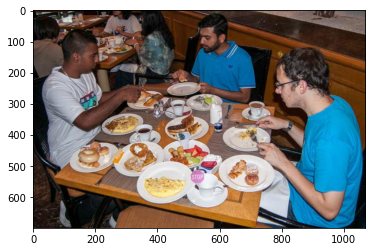

{'boxes': tensor([[785., 128., 803., 153.],
        [505., 513., 550., 558.]]), 'labels': tensor([5, 1]), 'image_id': tensor([0]), 'area': tensor([176400., 123201.]), 'iscrowd': tensor([False, False])}


In [6]:
dataset_train_ = fake_dataset("blender/out", "backgrounds_coco", 1000, (2, 5), 700, (300, 600))
img, target = dataset_train_.__getitem__(0)
plt.figure()
plt.imshow(img)
plt.show()
print(target)

In [7]:
test_img, test_target = dataset_train.__getitem__(0)
#model([test_img], [test_target])

In [8]:
from torch.utils.tensorboard import SummaryWriter
from detection.utils import MetricLogger
from detection.coco_eval import CocoEvaluator
import csv


summaryWriter = None
fieldnames = set()
rows = []
def log_loss(loss: MetricLogger, sw: SummaryWriter, epoch, pre=""):
    if len(rows) < epoch+1:
        rows.append({})
    
    for key, value in loss.meters.items():
        fieldnames.add(pre + key)
        rows[epoch][pre + key] = value.avg

        sw.add_scalar(pre + key, value.avg, epoch)
        #sw.add_scalar(key + "_smoothed", value., epoch)
eval_names = ["Precision: IoU 0.5 .. 0.95",
              "Precision: IoU 0.5",
              "Precision: IoU 0.75",
              "Precision: Small",
              "Precision: Medium",
              "Precision: Large",
              "Recall: Max_Det 1",
              "Recall: Max_Det 10",
              "Recall: Max_Det 100",
              "Recall: Small",
              "Recall: Medium",
              "Recall: Large",]
def log_eval(eval: CocoEvaluator, sw: SummaryWriter, epoch):
    if len(rows) < epoch+1:
        rows.append({})

    for iou_type, coco_eval in eval.coco_eval.items():
        for id, value in enumerate(coco_eval.stats):
            fieldnames.add(eval_names[id])
            rows[epoch][eval_names[id]] = value
            
            sw.add_scalar(eval_names[id], value, epoch)

def save_csv(file):
    with open(file, 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames)
        writer.writeheader()
        writer.writerows(rows)    

In [9]:
for model_name, model, batch_size, learning_rate, step_size, num_epochs in get_hyp():
        train_loader = DataLoader(dataset_train, batch_size, collate_fn=utils.collate_fn)
        run_name = f"Fake_Model_{model_name},B_{batch_size},LR_{learning_rate},StepSize_{step_size}"
        summaryWriter = SummaryWriter(log_dir=os.path.join("runs", run_name))
        
        if not os.path.exists(os.path.join("models", run_name)):
                os.makedirs(os.path.join("models", run_name))


        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=learning_rate,momentum=0.9, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=0.1)

        from detection.engine import train_one_epoch, evaluate
        print(device)
        for epoch in range(num_epochs):
                # train for one epoch, printing every 10 iterations
                loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
                log_loss(loss, summaryWriter, epoch)
                # update the learning rate
                lr_scheduler.step()
                # evaluate on the test dataset
                with torch.no_grad():
                        loss = train_one_epoch(model, optimizer, eval_loader, device, epoch, print_freq=100, eval=False)
                        log_loss(loss, summaryWriter, epoch, "eval_")
                eval = evaluate(model, eval_loader, device=device)
                log_eval(eval, summaryWriter, epoch)
                torch.save(model,os.path.join("models", run_name, f"epoch_{epoch}.pth"))
        save_csv(os.path.join("runs", run_name + ".csv"))

cuda
Epoch: [0]  [  0/150]  eta: 1:01:01  lr: 0.000039  loss: 2.8373 (2.8373)  loss_classifier: 2.1082 (2.1082)  loss_box_reg: 0.0168 (0.0168)  loss_objectness: 0.6977 (0.6977)  loss_rpn_box_reg: 0.0146 (0.0146)  time: 24.4086  data: 0.8580  max mem: 1478


KeyboardInterrupt: 

In [ ]:
#torch.save(model,"models/fcos_resnet50_fpn.pth")